# Use trained model to segment a video, get the segmentations and motion vector fields from the model outputs, apply transformations to convert ED/ES frame segementations into points and try using the motion vector fields to warp the points say from ED to ES to see if it directly equates the same point set of ES gotten from the segmentation (unfortunately, no, they don't match up) -- Haven't figured out why.

In [1]:
model_name = "Original_Pretrained_R2plus1D_18_MotionNet.pth"

# model_name = "dropout_v3_0_10_R2plus1D_18_MotionNet.pth"

In [2]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.misc import load_model_by_name

# for finding lv seg borders
import cv2 as cv

# for storing vector snapshots
import copy

# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.15it/s]


In [4]:
model_save_path = f"save_models/{model_name}"
    
model = load_model_by_name(model_name, model_save_path)

gpus detected: 4
using cuda
Original_Pretrained_R2plus1D_18_MotionNet.pth has 31575731 parameters.


In [5]:
from src.strain import *

In [6]:
%matplotlib widget

In [7]:
N = 3
test_pat_index = 0

curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)
    
ed_raw_seg_out = curr_clip_segmentations[:,0,...]

ed_one_hot_seg_out = one_hot(ed_raw_seg_out)

In [8]:
for i in range(delta_ed_es):
    print( np.max(curr_clip_motions[0][i][40][50]))

0.06214205175638199
0.05683978274464607
0.04324166849255562
0.03719091787934303
0.02990388125181198
0.025907931849360466
0.010116067714989185
-0.06244361028075218
-0.15422844886779785
-0.1391504406929016
-0.1265917718410492
-0.10494685918092728
-0.08403867483139038
-0.07937122136354446
-0.07516161352396011
-0.06378105282783508


Note: these are really small values, what are the units of them? who knows. If you think about the vector as a fraction of a pixel per frame, then it will take on the order of 10 frames at the same magnitude in order to move by a fraction of a "pixel". 

In [9]:
I = ed_one_hot_seg_out
# I = ed_label

I_regional_point_sets = image_to_regional_point_sets(I)

/home/wmw015/summer2022research/echo_22/dev/longitudinal_strain/src/strain.py:1019: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  multichannel=False)
/home/wmw015/summer2022research/echo_22/dev/longitudinal_strain/src/strain.py:1156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  I_regional_point_sets = np.array(I_regional_point_sets)


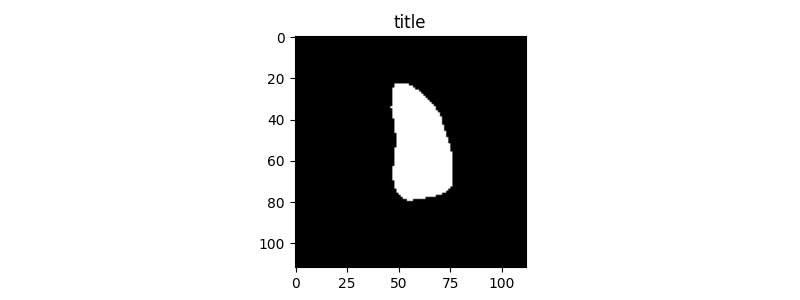

In [10]:
vis_single(I, cmap='gray')

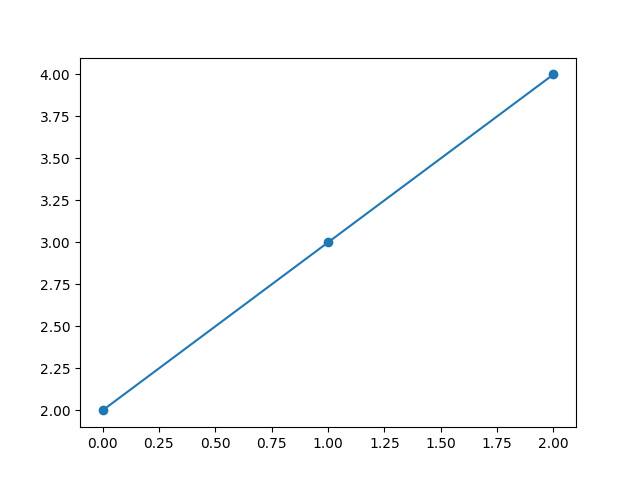

In [11]:
%matplotlib widget

from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot([0,1,2], [2,3,4] ,"o-")

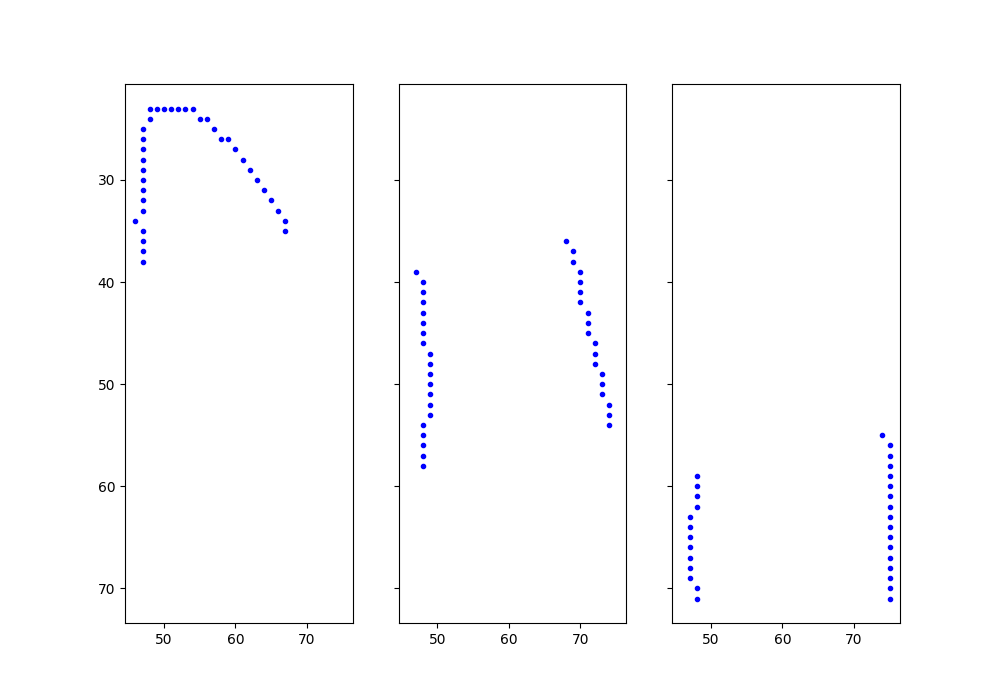

In [12]:
vis_three_point_sets(I_regional_point_sets)

In [13]:
I_regional_point_sets.shape

(3,)

In [14]:
I_regional_point_sets[0].shape

(36, 2)

In [15]:
def vis_single_point_set_from_vectors(ps_vectors):
    ''' ps_vectors - (N, ) np array storing vectors with format (x, y, delta_x, delta_y) '''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    x = []
    y = []
    for v in ps_vectors:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax.scatter(x, y, marker='.', color='b')
    ax.invert_yaxis()

In [16]:
def vis_single_point_set(ps):
    ''' ps - (N, 2) stored in (x,y)'''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    ax.scatter(ps[:, 0], ps[:, 1], marker='.', color='b')
    ax.invert_yaxis()

In [17]:
def image_to_whole_point_set(I):
    '''
    I - (112, 112) whole image segmentation
    points - (N, 2) stored in x, y
    '''
    I = give_boundary_no_basal_plane(I)
    points = []
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i][j] == 1:
                points.append(np.array([j, i]))
    return np.array(points)

## break

In [18]:
def convert_point_set_ij_into_xy(ps_ij):
    ''' 
    converts a point set of shape (M, 2) of points in the (i,j) format into 
    point set of shape (M, 2) of points in the (x,y) format where
    x = j
    y = i
    
    input: ps_ij - (M , 2)
    output: ps_xy - (M, 2)
        
    '''
    ps_xy = []
    for point in ps_ij:
        ps_xy.append(np.array([point[1], point[0]]))
    return np.array(ps_xy)

In [19]:
def convert_point_set_xy_into_vectors(ps_xy):
    '''
    converts a single point set passed in of shape (M, 2) into a np array of vector adts of shape (M, ) 
    vectors will have x,y with zero magnitudes representing deltas
    
    assumes the Vector ADT class definition is accessible in global scope
 
    input: ps_xy - (M, 2)
    output: ps_vectors - (M, )
    '''
    ps_vectors = []
    for point in ps_xy:
        ps_vectors.append(Vector(point[0], point[1], 0, 0))
    return np.array(ps_vectors)

In [20]:
apical_point_set = I_regional_point_sets[0]

apical_point_set = convert_point_set_ij_into_xy(apical_point_set)

apical_point_set = convert_point_set_xy_into_vectors(apical_point_set)

In [21]:
previous_apical_point_set = apical_point_set

In [22]:
print(previous_apical_point_set[0])

tail_x: 48
tail_y: 23
mag_x: 0
mag_y: 0



In [23]:
def warp_one_vector_forward_once(v, frame, motion, scale=1.0):
    '''
    input: 
        v - vector to warp
            should have base values: (x_i, y_j, 0, 0)
        frame - frame integer index
        motion - motion object of shape (4, 32, 112, 112)
    output:
        v_new - vector after warped from given frame
            base values: (x_i+1, y_j+1, 0, 0)
            
    frame given determines what motion tracking information to use
    as the frame integer value will be used to index motion
    '''
    # get surrounding vectors forming the unit square
    inted_i, inted_j = int(v.tail_y), int(v.tail_x)
    surr_vec_tails = [ [inted_i, inted_j],
                       [inted_i, inted_j+1],
                       [inted_i+1, inted_j],
                       [inted_i+1, inted_j+1] ]
    
    surround_vectors = []

    for _ in surr_vec_tails:
        i,j = _[0], _[1]
        x = j
        y = i

        forward_x = motion[0][frame][i][j]
        forward_y = motion[1][frame][i][j]

        surround_vectors.append(Vector(x, y, forward_x, forward_y))
        
    # convert magnitudes into polar, bilinearly interpolate new vector magnitude in polar
    # to the input vector v's tail_x, tail_y, convert back into 
    # cartesian, apply the warp, clear out conversion value holders
    v_new = vector_bilinear_interpolation(vectors=surround_vectors, new_vector=v)
    v_new.update_mag_xy_from_conversion()
    
    v_new.mag_x *= scale
    v_new.mag_y *= scale
    
    v_new.update_tails_from_mags()
    
    v_new.clear_conversion_mags_xy()
    v_new.clear_conversion_mags_rhotheta()
    v_new.clear_magnitudes()
    
    return v_new

In [24]:
def warp_one_vector_forward_delta_times(v, motion, delta, scale=1.0):
    ''' 
    handles warping forward a single vector specifically delta times and returns the new vector 
    
    input:
        v - vector to warp
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    '''
    for i in range(delta):
        v = warp_one_vector_forward_once(v, i, motion, scale)
    return v

In [25]:
def warp_one_point_set_forward_delta_times(ps_vectors, motion, delta, scale=1.0):
    '''
    input:
        ps_vectors - (M, )
            input vectors of base values (x_i, y_i, 0, 0)
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    output:
        ps_vectors_new - (M, )
            new vectors of base values (x_i+delta, y_i+delta, 0, 0)
                if save_mag flag is False
    '''
    ps_vectors = copy.deepcopy(ps_vectors)
    
    ps_vectors_new = []
    for v in ps_vectors:
        ps_vectors_new.append(warp_one_vector_forward_delta_times(v, motion, delta, scale))
    return np.array(ps_vectors_new)

In [26]:
new_apical_point_set = warp_one_point_set_forward_delta_times(ps_vectors = apical_point_set, 
                                       motion = curr_clip_motions,
                                       delta = delta_ed_es)

In [27]:
new_apical_point_set.shape

(36,)

In [28]:
apical_point_set.shape

(36,)

In [29]:
print(new_apical_point_set[1])

tail_x: 48.53722272525961
tail_y: 22.882592477971937
mag_x: 0
mag_y: 0



In [30]:
print(apical_point_set[0])

tail_x: 48
tail_y: 23
mag_x: 0
mag_y: 0



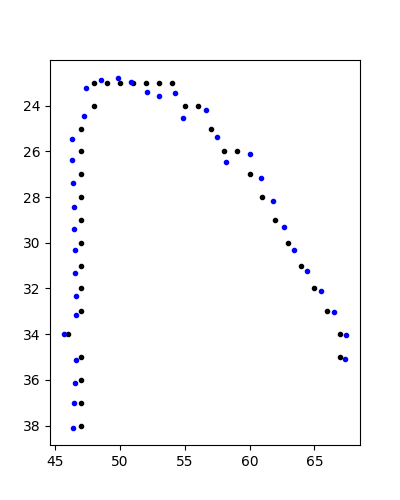

In [31]:
f, ax = plt.subplots(1, 1, figsize=(4, 5))
x = []
y = []
for v in new_apical_point_set:
    x.append(v.tail_x)
    y.append(v.tail_y)
ax.scatter(x, y, marker='.', color='b', zorder=2)
x = []
y = []
for v in previous_apical_point_set:
    x.append(v.tail_x)
    y.append(v.tail_y)
ax.scatter(x, y, marker='.', color='k', zorder=1)
ax.invert_yaxis()

## Ok, still not much change when you directly apply the warp information.

## How about instead look at the actualy values of the vector magnitudes at a single point to see if the values themselves are even that big ? 

In [32]:
x, y = 48, 23
x_deltas = []
y_deltas = []
for i in range(delta_ed_es):
    x_deltas.append(curr_clip_motions[0][i][y][x])
    y_deltas.append(curr_clip_motions[1][i][y][x])
x_deltas_sum = np.sum(x_deltas)
y_deltas_sum = np.sum(y_deltas)

In [33]:
x_deltas

[-0.021140241995453835,
 -0.026196304708719254,
 -0.0494956448674202,
 -0.06004045903682709,
 -0.06438732147216797,
 -0.0684315636754036,
 -0.06766533106565475,
 -0.06786208599805832,
 -0.049437880516052246,
 -0.03167957812547684,
 -0.025557033717632294,
 -0.024195939302444458,
 -0.030918002128601074,
 -0.032414522022008896,
 -0.03740338981151581,
 -0.040000997483730316]

In [34]:
y_deltas

[0.02079663798213005,
 0.012609841302037239,
 0.0005466490401886404,
 -0.0048307995311915874,
 0.008012928068637848,
 0.005976248066872358,
 0.01549478992819786,
 0.014148974791169167,
 0.008465087972581387,
 0.012599777430295944,
 0.013832253403961658,
 0.01850013993680477,
 0.017060628160834312,
 0.016323093324899673,
 0.015574902296066284,
 0.015869179740548134]

In [35]:
x_deltas_sum, y_deltas_sum

(-0.6968262959271669, 0.19098033191403374)

## Ok, so the vector magnitudes themselves are not that big, what kind of difference should we expect?
## Let's at the point sets for a patient at the `ED` and `ES` frame from the auto segmentation

In [36]:
ed_points = image_to_whole_point_set(ed_one_hot_seg_out)

es_points = image_to_whole_point_set(one_hot(curr_clip_segmentations[:,delta_ed_es,...]))

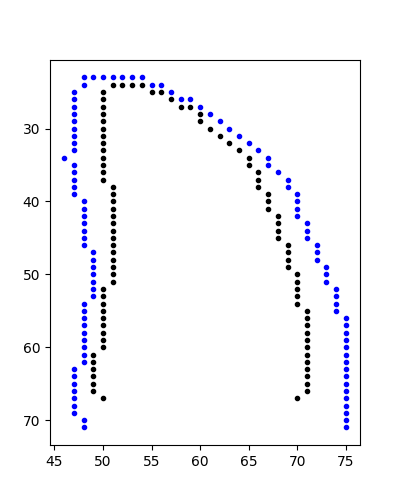

In [37]:
f, ax = plt.subplots(1, 1, figsize=(4, 5))
ax.scatter(ed_points[:, 0], ed_points[:, 1], marker='.', color='b', zorder=1)
ax.scatter(es_points[:, 0], es_points[:, 1], marker='.', color='k', zorder=2)
ax.invert_yaxis()

In [38]:
ed_points[0], es_points[0]

(array([48, 23]), array([51, 24]))

There's no way to actually know if this first point is the same first point in frames `ED` and `ES`. But let's assume it is and see what kind of delta_x and delta_y we need.

In [39]:
es_points[0][0] - ed_points[0][0], es_points[0][1] - ed_points[0][1]

(3, 1)

Need <u>integer</u> values of deltas...in comparison, we have deltas in our motion tracking on the scale of 1e-2 for every frame, and only after you sum them up for delta_ed_es times you get on scale of 1e-1

## Show how one point/vector traverses from frame `ED` to frame `ES`

In [40]:
# one vector and show its progression thru time
# that means we'll need to keep all of the intermediate vectors of this single point being traversed thru time/frame

multiple_time_snapshots_of_vector_id_0 = []

vector_id_0 = apical_point_set[0]

v = vector_id_0 # (x_0, y_0, delta_x_0, delta_y_0)
v.mag_x = curr_clip_motions[0][0][v.tail_y][v.tail_x]
v.mag_y = curr_clip_motions[1][0][v.tail_y][v.tail_x]


multiple_time_snapshots_of_vector_id_0.append(v)



for frame in range(delta_ed_es):
    frame += 1
    
    new_vect = copy.deepcopy(multiple_time_snapshots_of_vector_id_0[-1])

    new_vect.update_tails_from_mags()
    
    new_vect.clear_magnitudes()
    new_vect.clear_conversion_mags_xy()
    new_vect.clear_conversion_mags_rhotheta()

    # now interpolate to get delta_x_1, delta_y_1
    # get surrounding vectors forming the unit square
    # v = copy.deepcopy(new_vect)
    inted_i, inted_j = int(new_vect.tail_y), int(new_vect.tail_x)
    surr_vec_tails = [ [inted_i, inted_j],
                       [inted_i, inted_j+1],
                       [inted_i+1, inted_j],
                       [inted_i+1, inted_j+1] ]

    surround_vectors = []

    for _ in surr_vec_tails:
        i,j = _[0], _[1]
        x = j
        y = i

        forward_x = curr_clip_motions[0][frame][i][j]
        forward_y = curr_clip_motions[1][frame][i][j]

        surround_vectors.append(Vector(x, y, forward_x, forward_y))

    # convert magnitudes into polar, bilinearly interpolate new vector magnitude in polar
    # to the input vector v's tail_x, tail_y, convert back into 
    # cartesian, apply the warp, clear out conversion value holders
    v_new = vector_bilinear_interpolation(vectors=surround_vectors, new_vector=new_vect)

    v_new.update_mag_xy_from_conversion()
    
    delta_x_1 = v_new.mag_x
    delta_y_1 = v_new.mag_y

    new_vect.mag_x = delta_x_1
    new_vect.mag_y = delta_y_1

    multiple_time_snapshots_of_vector_id_0.append(new_vect)
    # else:
    #     # all other frames i > 1
    #     new_vect.update_tails_from_mags()
    #     new_vect.mag_x = 0
    #     new_vect.mag_y = 0
    
    

# # we want to save vectors in a manner just for visualization, not for actual usage
# # (x_1, y_1, delta_x_1, delta_y_1)

# for i in range(delta_ed_es):
#     delta_x_0 = curr_clip_motions[0][i][v
#     delta_y_0 = 
    
#     v_next = warp_one_vector_forward_once(v, i, curr_clip_motions)

In [41]:
# last point does not need magnitude as that point should be the point in the ES frame
multiple_time_snapshots_of_vector_id_0[-1].clear_magnitudes()

In [42]:
len(multiple_time_snapshots_of_vector_id_0)

17

In [43]:
delta_ed_es

16

In [44]:
for v in multiple_time_snapshots_of_vector_id_0:
    print(v)

tail_x: 48
tail_y: 23
mag_x: -0.021140241995453835
mag_y: 0.02079663798213005

tail_x: 47.978859758004546
tail_y: 23.02079663798213
mag_x: -0.026336712927948685
mag_y: 0.013789030554144651

tail_x: 47.952523045076596
tail_y: 23.034585668536273
mag_x: -0.04908962801518154
mag_y: 0.004344389495551597

tail_x: 47.903433417061414
tail_y: 23.038930058031823
mag_x: -0.04076678190501701
mag_y: -0.043338890447889286

tail_x: 47.862666635156394
tail_y: 22.995591167583935
mag_x: -0.06507974246243105
mag_y: 0.01243813839120562

tail_x: 47.797586892693964
tail_y: 23.008029305975143
mag_x: -0.06946048264158522
mag_y: 0.01264880529058956

tail_x: 47.728126410052376
tail_y: 23.02067811126573
mag_x: -0.06437717403710327
mag_y: 0.020970881155636854

tail_x: 47.66374923601527
tail_y: 23.04164899242137
mag_x: -0.057458145527297305
mag_y: 0.01791508159521544

tail_x: 47.60629109048797
tail_y: 23.059564074016585
mag_x: -0.04056310570787021
mag_y: 0.016882047101849148

tail_x: 47.565727984780104
tail_y: 23.

In [45]:
def vis_one_vec_multiple_frames(all_vectors):
    '''
    input: all_vectors - python list of Vector ADTs
    
    '''
    
    x_tails = []
    y_tails = []
    x_mags = []
    y_mags = []

    for v in all_vectors:
        x_tails.append(v.tail_x)
        y_tails.append(v.tail_y)

        x_mags.append(v.mag_x)
        y_mags.append(v.mag_y)

    # vector field
    f, ax = plt.subplots(1,2,figsize=(8, 5))
    ax[0].quiver(x_tails, y_tails, x_mags, y_mags, color='k', linewidth=0.7)
    ax[0].invert_yaxis()
    
    # scatter plot, color gradient points
    ax[1].scatter(x_tails, y_tails, c=np.linspace(0,1,len(x_tails)))
    ax[1].invert_yaxis()

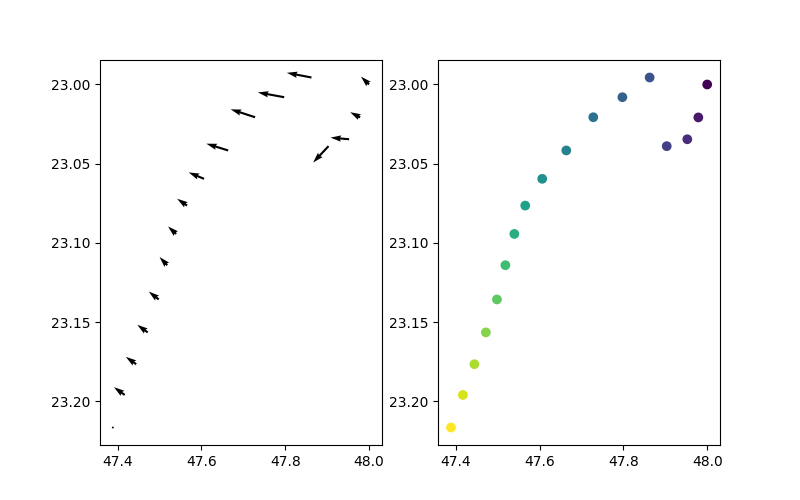

In [46]:
# print all the vectors
vis_one_vec_multiple_frames(multiple_time_snapshots_of_vector_id_0)

In [47]:
multiple_time_snapshots_of_vector_id_0

In [48]:
for v in multiple_time_snapshots_of_vector_id_0:
    print(v)

tail_x: 48
tail_y: 23
mag_x: -0.021140241995453835
mag_y: 0.02079663798213005

tail_x: 47.978859758004546
tail_y: 23.02079663798213
mag_x: -0.026336712927948685
mag_y: 0.013789030554144651

tail_x: 47.952523045076596
tail_y: 23.034585668536273
mag_x: -0.04908962801518154
mag_y: 0.004344389495551597

tail_x: 47.903433417061414
tail_y: 23.038930058031823
mag_x: -0.04076678190501701
mag_y: -0.043338890447889286

tail_x: 47.862666635156394
tail_y: 22.995591167583935
mag_x: -0.06507974246243105
mag_y: 0.01243813839120562

tail_x: 47.797586892693964
tail_y: 23.008029305975143
mag_x: -0.06946048264158522
mag_y: 0.01264880529058956

tail_x: 47.728126410052376
tail_y: 23.02067811126573
mag_x: -0.06437717403710327
mag_y: 0.020970881155636854

tail_x: 47.66374923601527
tail_y: 23.04164899242137
mag_x: -0.057458145527297305
mag_y: 0.01791508159521544

tail_x: 47.60629109048797
tail_y: 23.059564074016585
mag_x: -0.04056310570787021
mag_y: 0.016882047101849148

tail_x: 47.565727984780104
tail_y: 23.

## Ok, let's just create the visualization of three regional point sets with ED and ES overlapping

In [49]:
I_ED_and_ES_regional_point_sets_as_vectors = {}
I_ED_and_ES_regional_point_sets_as_vectors['ED'] = []
I_ED_and_ES_regional_point_sets_as_vectors['ES'] = []


for IND in range(N):
    ps = I_regional_point_sets[IND]

    ps = convert_point_set_ij_into_xy(ps)

    ps = convert_point_set_xy_into_vectors(ps)

    new_ps = warp_one_point_set_forward_delta_times(ps_vectors = ps, 
                                           motion = curr_clip_motions,
                                           delta = delta_ed_es)

    I_ED_and_ES_regional_point_sets_as_vectors['ED'].append(ps)
    I_ED_and_ES_regional_point_sets_as_vectors['ES'].append(new_ps)

In [50]:
def vis_double_three_point_sets(vectors_dict, title='ED Blue | ES Red'):
    '''
    vectors_dict - two keys 'ED' and 'ES'
        each point to an array of three point sets representing regional points (apical, mid, basal) ... or more depending on N...well it's hardcoded for now
    '''
    fig, ax = plt.subplots(1,3, figsize=(10,7), sharex = True, sharey = True)
    x = []
    y = []
    for v in vectors_dict['ED'][0]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[0].scatter(x, y, marker='.', color='b', zorder=1)     # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][0]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[0].scatter(x, y, marker='.', color='r', zorder=2) # ES
    ax[0].invert_yaxis()
    ax[0].set_title('Apical')

    
    x.clear()
    y.clear()
    for v in vectors_dict['ED'][1]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[1].scatter(x, y, marker='.', color='b', zorder=1)    # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][1]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[1].scatter(x, y, marker='.', color='r', zorder=2)# ES
    ax[1].invert_yaxis()
    ax[1].set_title('Mid')

    
    x.clear()
    y.clear()
    for v in vectors_dict['ED'][2]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[2].scatter(x, y, marker='.', color='b', zorder=1)    # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][2]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[2].scatter(x, y, marker='.', color='r', zorder=2)# ES
    ax[2].invert_yaxis()
    ax[2].set_title('Basal')
    
    fig.suptitle(title)

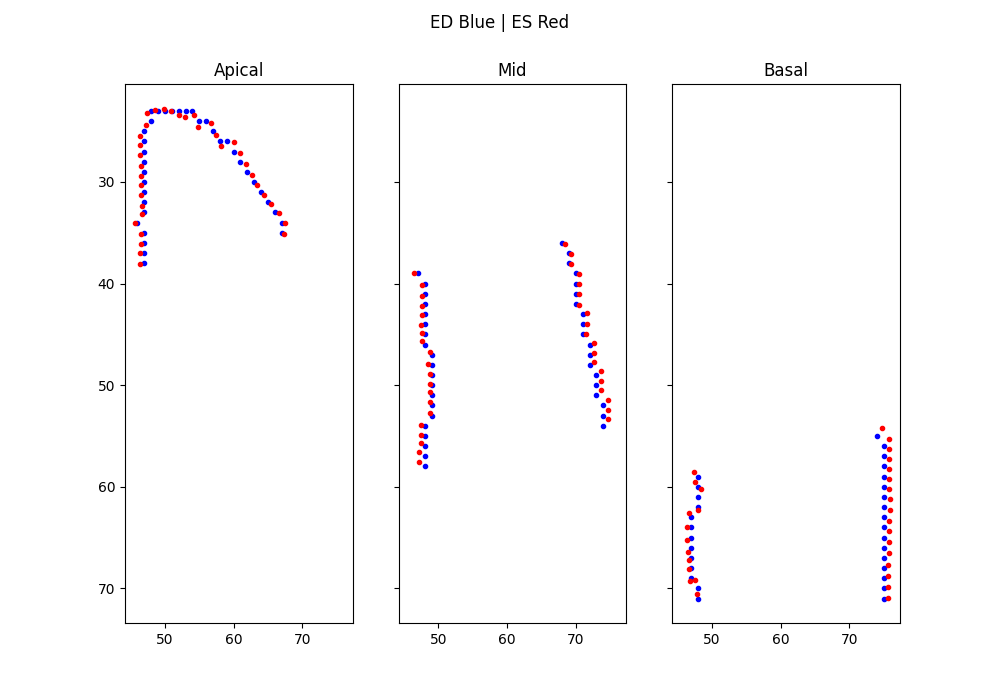

In [51]:
vis_double_three_point_sets(vectors_dict = I_ED_and_ES_regional_point_sets_as_vectors)

## Compare that using model's ED segmentation output with the point sets gotten directly from the Dataset labels

In [52]:
ground_truth_I_ED_and_ES_regional_point_sets_as_vectors = {}
ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ED'] = []
ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ES'] = []

ed_regional_point_sets = image_to_regional_point_sets(ed_label)
es_regional_point_sets = image_to_regional_point_sets(es_label)

for IND in range(N):
    ed_ps = ed_regional_point_sets[IND]
    ed_ps = convert_point_set_ij_into_xy(ed_ps)
    ed_ps = convert_point_set_xy_into_vectors(ed_ps)
    
    es_ps = es_regional_point_sets[IND]
    es_ps = convert_point_set_ij_into_xy(es_ps)
    es_ps = convert_point_set_xy_into_vectors(es_ps)

    
    ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ED'].append(ed_ps)
    ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ES'].append(es_ps)

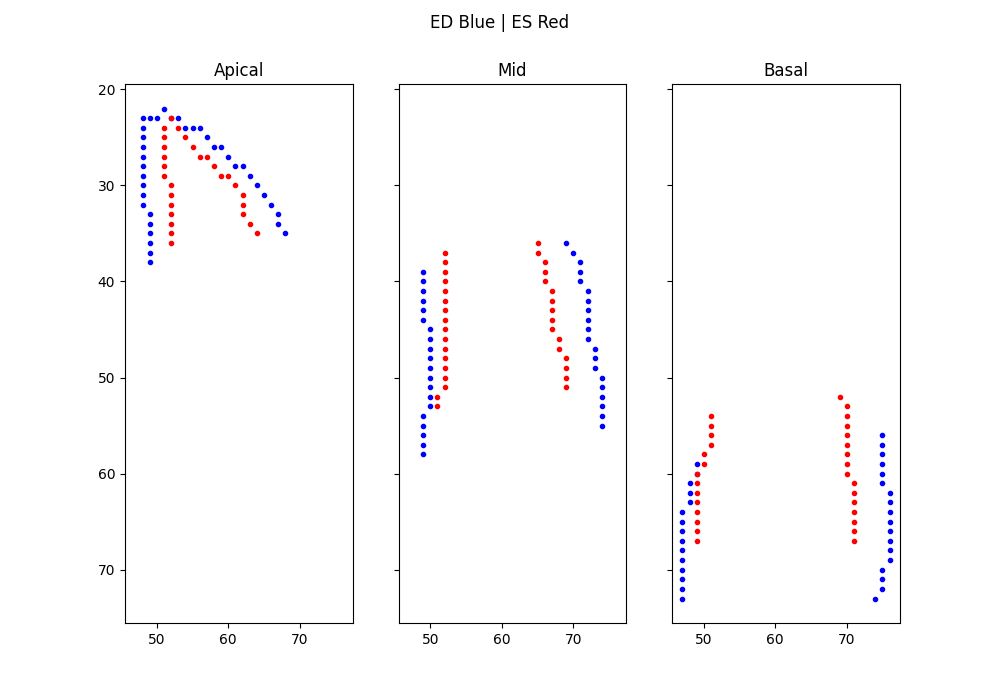

In [53]:
vis_double_three_point_sets(vectors_dict = ground_truth_I_ED_and_ES_regional_point_sets_as_vectors)

## Let's try scaling the magnitudes of the vectors and see if we get better movement? But I wouldn't think so??
How am I choosing a value for the scale? Arbitrary guesses. Just trying values out and seeing what it looks like. Scaling the vectors is purely for curiosity, and it should be noted that it does not make sense to actually scale them and use those vectors in any sort of automated software product. I personally so far don't see any applicability of these motion vector fields, so far. Unless it can be explained why they are so small in value, I'm not sure we can apply them directly to segmentation logits. I think I am not understanding things correctly.

In [62]:
scale = -5.5

I_ED_and_ES_regional_point_sets_as_vectors_1 = {}
I_ED_and_ES_regional_point_sets_as_vectors_1['ED'] = []
I_ED_and_ES_regional_point_sets_as_vectors_1['ES'] = []


for IND in range(N):
    ps = I_regional_point_sets[IND]

    ps = convert_point_set_ij_into_xy(ps)

    ps = convert_point_set_xy_into_vectors(ps)

    new_ps = warp_one_point_set_forward_delta_times(ps_vectors = ps, 
                                           motion = curr_clip_motions,
                                           delta = delta_ed_es,
                                           scale = scale)

    I_ED_and_ES_regional_point_sets_as_vectors_1['ED'].append(ps)
    I_ED_and_ES_regional_point_sets_as_vectors_1['ES'].append(new_ps)

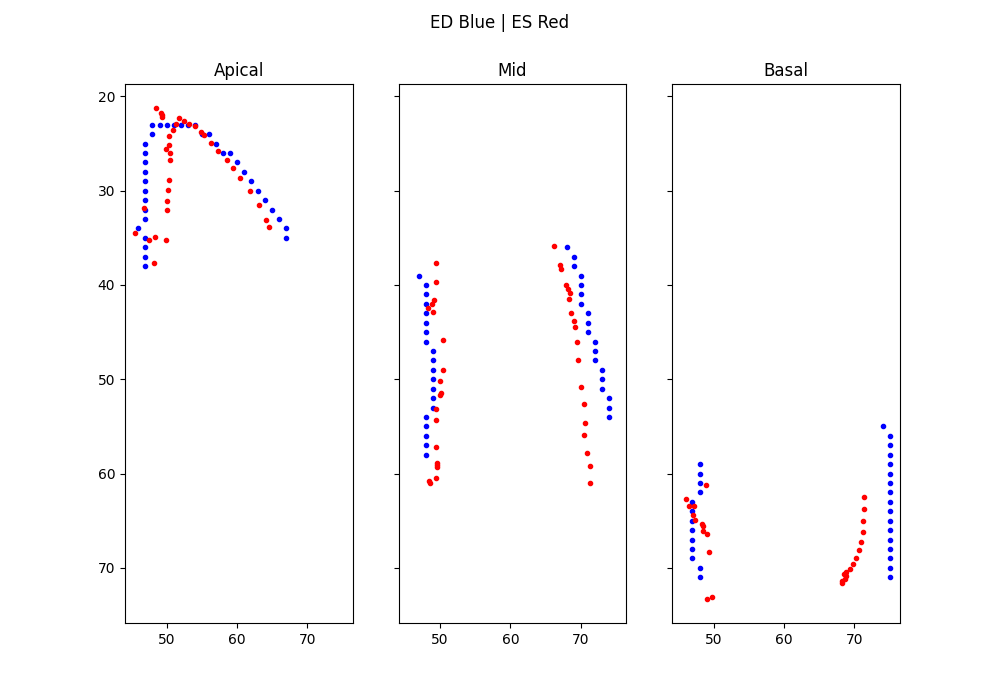

In [63]:
vis_double_three_point_sets(vectors_dict = I_ED_and_ES_regional_point_sets_as_vectors_1)